In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
import nltk
from nltk.corpus import stopwords
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [75]:
df = pd.read_csv('sentimentdataset.csv')
print(df.head())

   Unnamed: 0.1  Unnamed: 0  \
0             0           0   
1             1           1   
2             2           2   
3             3           3   
4             4           4   

                                                Text    Sentiment  \
0   Enjoying a beautiful day at the park!        ...   Positive     
1   Traffic was terrible this morning.           ...   Negative     
2   Just finished an amazing workout! 💪          ...   Positive     
3   Excited about the upcoming weekend getaway!  ...   Positive     
4   Trying out a new recipe for dinner tonight.  ...   Neutral      

             Timestamp            User     Platform  \
0  2023-01-15 12:30:00   User123          Twitter     
1  2023-01-15 08:45:00   CommuterX        Twitter     
2  2023-01-15 15:45:00   FitnessFan      Instagram    
3  2023-01-15 18:20:00   AdventureX       Facebook    
4  2023-01-15 19:55:00   ChefCook        Instagram    

                                     Hashtags  Retweets  Likes     

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0.1  732 non-null    int64  
 1   Unnamed: 0    732 non-null    int64  
 2   Text          732 non-null    object 
 3   Sentiment     732 non-null    object 
 4   Timestamp     732 non-null    object 
 5   User          732 non-null    object 
 6   Platform      732 non-null    object 
 7   Hashtags      732 non-null    object 
 8   Retweets      732 non-null    float64
 9   Likes         732 non-null    float64
 10  Country       732 non-null    object 
 11  Year          732 non-null    int64  
 12  Month         732 non-null    int64  
 13  Day           732 non-null    int64  
 14  Hour          732 non-null    int64  
dtypes: float64(2), int64(6), object(7)
memory usage: 85.9+ KB


In [43]:
sentiment_counts = df['Sentiment'].value_counts()
print(sentiment_counts)

Sentiment
Positive           44
Joy                42
Excitement         32
Neutral            14
Contentment        14
                   ..
Adrenaline          1
Harmony             1
ArtisticBurst       1
Radiance            1
Elegance            1
Name: count, Length: 279, dtype: int64


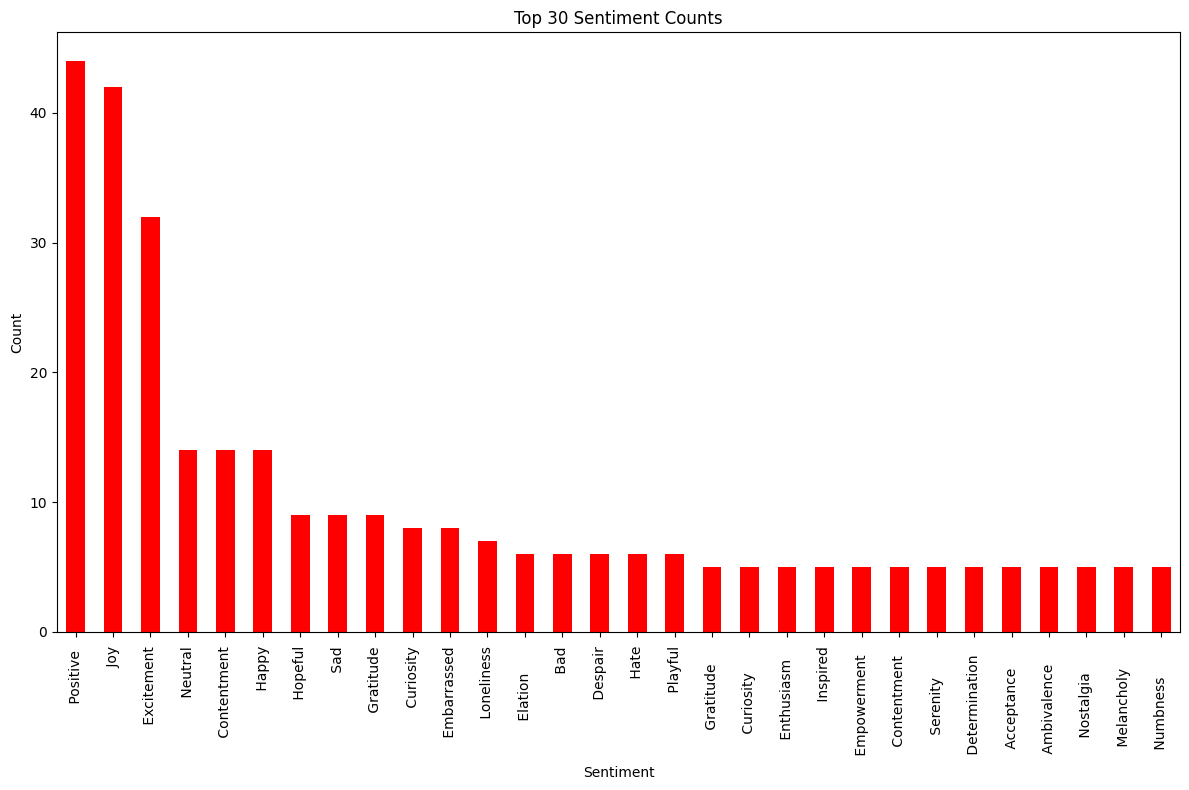

In [46]:
top30 = sentiment_counts.head(30)

plt.figure(figsize=(12, 8))
top30.plot(kind='bar', color='red')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Top 30 Sentiment Counts')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [76]:
# Label encoding for Sentiment

label_encoder = LabelEncoder()
df['Sentiment'] = label_encoder.fit_transform(df['Sentiment'])

In [77]:
# Cross-verifying Sentiment
sentiment_counts = df['Sentiment'].value_counts()
print(sentiment_counts)

Sentiment
214    44
172    42
110    32
196    14
56     14
       ..
7       1
142     1
23      1
222     1
90      1
Name: count, Length: 279, dtype: int64


Platform
Instagram     258
Facebook      231
Twitter       128
Twitter       115
Name: count, dtype: int64
Platform
Instagram    258
Twitter      243
Facebook     231
Name: count, dtype: int64


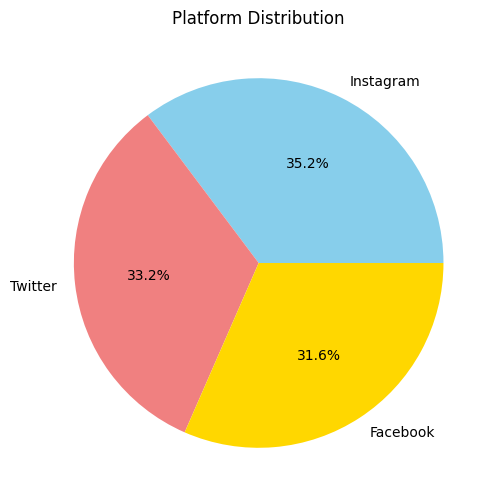

In [49]:
# Was done initially but was not used to train model

platform_counts = df['Platform'].value_counts()
print(platform_counts)
df["Platform"] = df["Platform"].str.strip()
platform_counts = df['Platform'].value_counts()
print(platform_counts)

plt.figure(figsize=(6, 6))
plt.pie(platform_counts, labels=platform_counts.index, autopct="%1.1f%%", colors=["skyblue", "lightcoral", "gold"])
plt.title("Platform Distribution")
plt.show()

In [50]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['Platform'] = label_encoder.fit_transform(df['Platform'])

In [97]:
# differentiating the input and output values
df_X = df['Text']
df_Y = df['Sentiment']

In [98]:
# removing stop words and other unnecessary words or elements
import re

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


def clean_text(text):
    text = text.lower()
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = ''.join(c for c in text if c.isascii())
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

df_X = df_X.apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Tokenizer + Padding approach

In [99]:
# Tokenizing with 3000 values
tokenizer = Tokenizer(num_words=3000)
tokenizer.fit_on_texts(df_X)
df_X = tokenizer.texts_to_sequences(df_X)

In [92]:
print(df_X[:5])

[[214, 294, 3, 410], [1048, 1049, 295], [623, 1050, 215], [624, 66, 77, 625], [121, 1, 296, 411, 412]]


In [100]:
# it was found that max len of text is 20 therefore padding to make all the text of length 20
X_sequences = pad_sequences(df_X, maxlen=20, padding='post', truncating='post')

y = df_Y
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y, test_size=0.1, random_state=42)

Trying various models to train for classification task:

In [101]:

model = Sequential([
    Embedding(input_dim=10000, output_dim=279, input_length=20),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(279, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.0216 - loss: 5.5913 - val_accuracy: 0.0541 - val_loss: 5.5471
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.0770 - loss: 5.1713 - val_accuracy: 0.1081 - val_loss: 5.6906
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.1182 - loss: 4.8969 - val_accuracy: 0.1216 - val_loss: 5.8765
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.1367 - loss: 4.5430 - val_accuracy: 0.1216 - val_loss: 5.8020
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.1562 - loss: 4.1591 - val_accuracy: 0.1081 - val_loss: 5.8370
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.1873 - loss: 3.6900 - val_accuracy: 0.0946 - val_loss: 6.1274
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.3033 - loss: 3.2284 - val_accuracy: 0.0946 - val_loss: 6.6916
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.4881 - loss: 2.5116 - val_accuracy: 0.1351 - v

In [102]:

model = Sequential([
    Embedding(input_dim=10000, output_dim=279, input_length=20),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(279, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.0087 - loss: 5.6306 - val_accuracy: 0.0135 - val_loss: 5.6298
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0171 - loss: 5.6270 - val_accuracy: 0.0811 - val_loss: 5.6278
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0672 - loss: 5.6238 - val_accuracy: 0.0946 - val_loss: 5.6259
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0741 - loss: 5.6199 - val_accuracy: 0.0946 - val_loss: 5.6238
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.0883 - loss: 5.6166 - val_accuracy: 0.0946 - val_loss: 5.6217
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.0731 - loss: 5.6142 - val_accuracy: 0.0946 - val_loss: 5.6197
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0777 - loss: 5.6097 - val_accuracy: 0.0946 - val_loss: 5.6176
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0761 - loss: 5.6076 - val_accuracy: 0.0946 - v

In [30]:
model = Sequential([
    Embedding(input_dim=10000, output_dim=279, input_length=20),
    Flatten(),
    Dense(100, activation='relu'),
    Dense(279, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.0448 - loss: 5.5660 - val_accuracy: 0.0541 - val_loss: 5.5330
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.0751 - loss: 5.1773 - val_accuracy: 0.1216 - val_loss: 5.6429
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.1472 - loss: 4.6745 - val_accuracy: 0.1216 - val_loss: 5.5868
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.1827 - loss: 4.2804 - val_accuracy: 0.1216 - val_loss: 5.6307
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.2177 - loss: 3.8924 - val_accuracy: 0.1081 - val_loss: 5.6903
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.3032 - loss: 3.4910 - val_accuracy: 0.1351 - val_loss: 5.8342
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.4240 - loss: 2.9598 - val_accuracy: 0.1216 - val_loss: 5.9504
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5179 - loss: 2.5069 - val_accuracy: 0.1351 - v

In [ ]:
# Define ANN Model
model = Sequential([
    Embedding(input_dim=10000, output_dim=279, input_length=20),  # Embedding layer
    Flatten(),
    Dense(5000, activation='relu'),
    Dense(500, activation='relu'),
    Dense(128, activation='relu'),
    Dense(279, activation='softmax')
])

# Compile Model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train Model
model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

# Evaluate Model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 497ms/step - accuracy: 0.0423 - loss: 5.5485 - val_accuracy: 0.1088 - val_loss: 5.4888
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 530ms/step - accuracy: 0.0949 - loss: 4.9830 - val_accuracy: 0.1088 - val_loss: 5.4100
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 517ms/step - accuracy: 0.1375 - loss: 4.2943 - val_accuracy: 0.1088 - val_loss: 5.7967
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 466ms/step - accuracy: 0.3453 - loss: 3.2139 - val_accuracy: 0.1497 - val_loss: 6.3683
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 479ms/step - accuracy: 0.5436 - loss: 2.0805 - val_accuracy: 0.1769 - val_loss: 7.4502
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 526ms/step - accuracy: 0.7161 - loss: 1.2486 - val_accuracy: 0.1905 - val_loss: 8.3816
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 528ms/step - accuracy: 0.9296 - loss: 0.4528 - val_accuracy: 0.1565 - val_loss: 11.7946
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 563ms/step - accuracy: 0.9720 - loss: 0.1398 - val_accu

In [103]:
model = Sequential([
    Embedding(input_dim=10000, output_dim=279, input_length=20),
    Flatten(),
    Dense(1000, activation='sigmoid'),
    Dense(700, activation='relu'),
    Dense(512, activation='relu'),
    Dense(279, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step - accuracy: 0.0331 - loss: 5.6451 - val_accuracy: 0.0541 - val_loss: 5.5056
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.0831 - loss: 5.1113 - val_accuracy: 0.1081 - val_loss: 5.6444
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.1252 - loss: 4.9678 - val_accuracy: 0.1216 - val_loss: 5.7643
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.1155 - loss: 4.6127 - val_accuracy: 0.1081 - val_loss: 5.5040
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.1280 - loss: 4.2288 - val_accuracy: 0.0676 - val_loss: 6.1125
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.1401 - loss: 3.9409 - val_accuracy: 0.1216 - val_loss: 6.1915
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.1816 - loss: 3.5900 - val_accuracy: 0.0676 - val_loss: 7.1866
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.2556 - loss: 3.2356 - val_accuracy: 0.

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.0381 - loss: 5.5770 - val_accuracy: 0.0676 - val_loss: 5.6029
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.0935 - loss: 5.1181 - val_accuracy: 0.1216 - val_loss: 5.6888
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.1573 - loss: 4.7375 - val_accuracy: 0.1081 - val_loss: 5.7461
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.1737 - loss: 4.3581 - val_accuracy: 0.1081 - val_loss: 5.6800
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.1968 - loss: 3.9697 - val_accuracy: 0.1081 - val_loss: 5.7721
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.2786 - loss: 3.5205 - val_accuracy: 0.1081 - val_loss: 5.8376
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.3973 - loss: 2.8904 - val_accuracy: 0.1216 - val_loss: 5.9327
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.5316 - loss: 2.3938 - val_accuracy: 0.1486 - val_loss: 6.

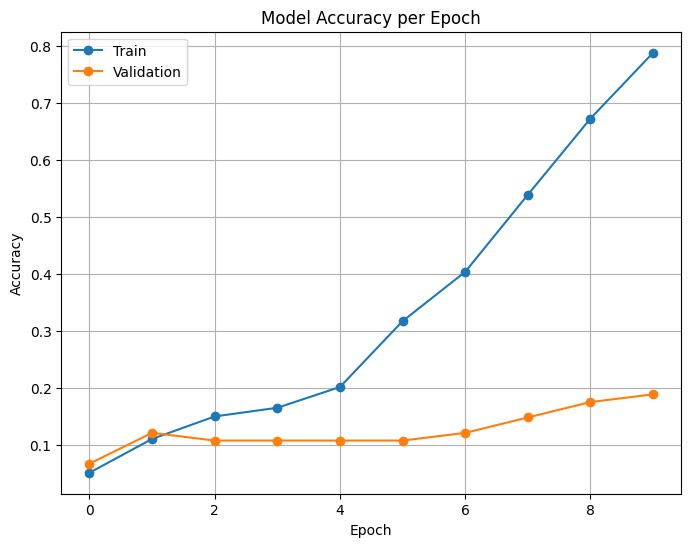

In [104]:
# Printing the best output
model = Sequential([
    Embedding(input_dim=10000, output_dim=279, input_length=20),
    Flatten(),
    Dense(100, activation='relu'),
    Dense(279, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Plot training & validation accuracy values
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], marker='o')
plt.plot(history.history['val_accuracy'], marker='o')
plt.title('Model Accuracy per Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.show()